In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


import warnings
warnings.filterwarnings('ignore')

print("Bibliothèques chargées !")

Bibliothèques chargées !


In [2]:
# Téléchargement du dataset NSL-KDD depuis GitHub

!wget -q https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain%2B.txt
!wget -q https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTest%2B.txt

In [3]:
# Liste des noms de colonnes du dataset NSL-KDD
# (trouvée dans la documentation du dataset)
columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
    'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
    'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
    'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
    'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
    'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label', 'difficulty'
]

# Chargement des données
df_train = pd.read_csv('KDDTrain+.txt', names=columns)
df_test = pd.read_csv('KDDTest+.txt', names=columns)

print(f"Données d'entraînement: {df_train.shape}")
print(f"Données de test: {df_test.shape}")

Données d'entraînement: (125973, 43)
Données de test: (22544, 43)


In [20]:
# Afficher les premières lignes
print("Aperçu des données:")
print(df_train.head())

print("\nTypes de données:")
print(df_train.dtypes)

print("\nVérification des valeurs manquantes:")
print(df_train.isnull().sum().sum(), "valeurs manquantes au total")

Aperçu des données:
   duration  protocol_type  service  flag  src_bytes  dst_bytes  land  \
0         0              1       20     9        491          0     0   
1         0              2       44     9        146          0     0   
2         0              1       49     5          0          0     0   
3         0              1       24     9        232       8153     0   
4         0              1       24     9        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                  25   
1               0       0    0  ...                   1   
2               0       0    0  ...                  26   
3               0       0    0  ...                 255   
4               0       0    0  ...                 255   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                    0.17                    0.03   
1                    0.00                    0.60   
2                    0.10  

In [32]:
# On va simplifier: Normal vs Attaque (classification binaire)
# Cela rendra le modèle plus facile à entraîner

# Cette fonction et les lignes suivantes ne sont plus nécessaires car
# la colonne 'label_binaire' existe déjà et la colonne 'label' originale a été supprimée.
# def simplifier_label(label):
#     if label == 'normal':
#         return 0  # Normal
#     else:
#         return 1  # Attaque

# df_train['label_binaire'] = df_train['label'].apply(simplifier_label)
# df_test['label_binaire'] = df_test['label'].apply(simplifier_label)

print("Distribution après simplification:")
print(df_train['label_binaire'].value_counts())

Distribution après simplification:
label_binaire
0    67343
1    58630
Name: count, dtype: int64


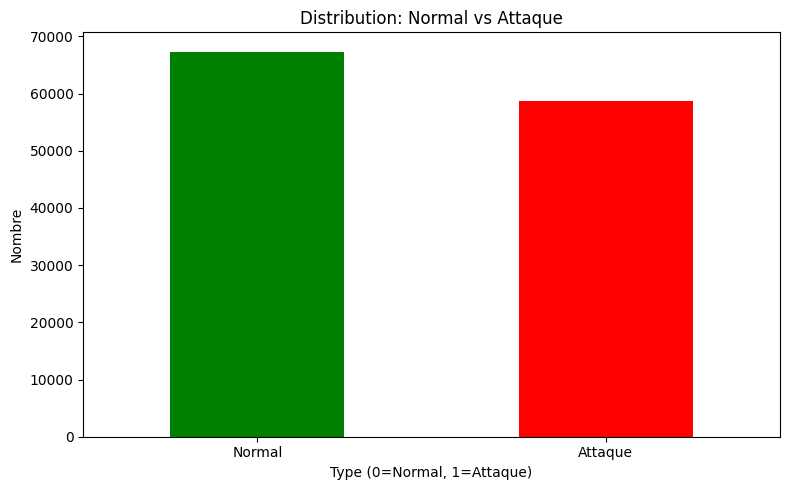

In [33]:
# Visualisation
plt.figure(figsize=(8, 5))
df_train['label_binaire'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title("Distribution: Normal vs Attaque")
plt.xlabel("Type (0=Normal, 1=Attaque)")
plt.ylabel("Nombre")
plt.xticks([0, 1], ['Normal', 'Attaque'], rotation=0)
plt.tight_layout()
plt.show()

In [34]:
# Identifier les colonnes catégorielles (texte)
colonnes_categoriques = ['protocol_type', 'service', 'flag']

print("Encodage des variables catégorielles...")

# Créer des encodeurs
encoders = {}
for col in colonnes_categoriques:
    le = LabelEncoder()
    # Combiner train et test pour avoir tous les labels
    all_values = pd.concat([df_train[col], df_test[col]])
    le.fit(all_values)

    df_train[col] = le.transform(df_train[col])
    df_test[col] = le.transform(df_test[col])

    encoders[col] = le

print("Encodage terminé !")
print(df_train[colonnes_categoriques].head())

Encodage des variables catégorielles...
Encodage terminé !
   protocol_type  service  flag
0              1       20     9
1              2       44     9
2              1       49     5
3              1       24     9
4              1       24     9


In [35]:
# Supprimer les colonnes qui ne servent pas

colonnes_a_supprimer = ['num_outbound_cmds', 'label', 'difficulty']

# Filtrer les colonnes à supprimer pour n'inclure que celles qui existent réellement dans df_train
colonnes_existantes_a_supprimer_train = [col for col in colonnes_a_supprimer if col in df_train.columns]
# Filtrer les colonnes à supprimer pour n'inclure que celles qui existent réellement dans df_test
colonnes_existantes_a_supprimer_test = [col for col in colonnes_a_supprimer if col in df_test.columns]

# Supprimer les colonnes si elles existent
if colonnes_existantes_a_supprimer_train:
    df_train = df_train.drop(columns=colonnes_existantes_a_supprimer_train)
    print(f"Colonnes supprimées de df_train: {colonnes_existantes_a_supprimer_train}")
else:
    print("Aucune des colonnes spécifiées n'était présente dans df_train.")

if colonnes_existantes_a_supprimer_test:
    df_test = df_test.drop(columns=colonnes_existantes_a_supprimer_test)
    print(f"Colonnes supprimées de df_test: {colonnes_existantes_a_supprimer_test}")
else:
    print("Aucune des colonnes spécifiées n'était présente dans df_test.")


print(f"Nombre de features restantes dans df_train: {df_train.shape[1] - 1}")  # -1 car label_binaire
print(f"Nombre de features restantes dans df_test: {df_test.shape[1] - 1}")

Aucune des colonnes spécifiées n'était présente dans df_train.
Aucune des colonnes spécifiées n'était présente dans df_test.
Nombre de features restantes dans df_train: 40
Nombre de features restantes dans df_test: 40


In [36]:
# Séparer les features (X) et la cible (y)
X_train = df_train.drop('label_binaire', axis=1)
y_train = df_train['label_binaire']

X_test = df_test.drop('label_binaire', axis=1)
y_test = df_test['label_binaire']

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (125973, 40)
y_train shape: (125973,)
X_test shape: (22544, 40)
y_test shape: (22544,)


In [37]:
# Normaliser les données (important pour certains algos ML)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Normalisation effectuée !")
print(f"Moyenne avant: {X_train.values.mean():.2f}")
print(f"Moyenne après: {X_train_scaled.mean():.2f}")

Normalisation effectuée !
Moyenne avant: 1652.16
Moyenne après: -0.00


In [38]:
# Créer le modèle Random Forest

# Paramètres
rf_model = RandomForestClassifier(
    n_estimators=100,      # Nombre d'arbres
    max_depth=20,          # Profondeur max
    random_state=42,       # Pour reproductibilité
    n_jobs=-1              # Utiliser tous les CPU
)

# Entraînement
rf_model.fit(X_train_scaled, y_train)


RandomForestClassifier(max_depth=20, n_jobs=-1, random_state=42)

In [14]:
# Faire des prédictions
y_pred = rf_model.predict(X_test_scaled)

In [15]:
# Calculer la précision
accuracy = accuracy_score(y_test, y_pred)
print(f"\nPrécision du modèle: {accuracy*100:.2f}%")

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
print("\nMatrice de confusion:")
print(cm)

# Rapport détaillé
print("\nRapport de classification:")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Attaque']))


Précision du modèle: 77.08%

Matrice de confusion:
[[9430  281]
 [4887 7946]]

Rapport de classification:
              precision    recall  f1-score   support

      Normal       0.66      0.97      0.78      9711
     Attaque       0.97      0.62      0.75     12833

    accuracy                           0.77     22544
   macro avg       0.81      0.80      0.77     22544
weighted avg       0.83      0.77      0.77     22544



In [16]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Créer le modèle XGBoost

# Paramètres
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'  # Pour éviter les warnings
)

# Entraînement
xgb_model.fit(X_train_scaled, y_train)

# Prédiction
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Résultats
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"\n🎯 Précision XGBoost: {accuracy_xgb*100:.2f}%")

# Rapport détaillé
print("\nRapport de classification:")
print(classification_report(y_test, y_pred_xgb, target_names=['Normal', 'Attaque']))


🎯 Précision XGBoost: 81.03%

Rapport de classification:
              precision    recall  f1-score   support

      Normal       0.70      0.97      0.82      9711
     Attaque       0.97      0.69      0.81     12833

    accuracy                           0.81     22544
   macro avg       0.84      0.83      0.81     22544
weighted avg       0.85      0.81      0.81     22544

